## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

from sqlalchemy import create_engine
import psycopg2

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced


from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

## Read the Data from Postgres

In [5]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [6]:
#Create a connection to the Postgres & AWS

# Import API key
from config import db_password

connection = psycopg2.connect(
    host = 'finalproject-ml.cvm9etk63tz8.us-west-1.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = db_password,
    database = 'postgres'
    )
cursor=connection.cursor()

In [7]:
#Read in Table
aqi_all = "select * from aqi_all"

In [8]:
#Check DataFrame
df = pd.read_sql(aqi_all, con=connection)
df.head()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10
0,2015-01-01,7.0,37.0,26.0,55.0,NaN
1,2015-01-02,8.0,42.0,20.0,73.0,NaN
2,2015-01-03,10.0,45.0,17.0,84.0,NaN
3,2015-01-04,10.0,40.0,19.0,86.0,NaN
4,2015-01-05,9.0,42.0,12.0,69.0,NaN


In [9]:
# Create AQI_Max Column
df["AQI_Max"] = pd.DataFrame(df.max(axis=1))
df.head()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
0,2015-01-01,7.0,37.0,26.0,55.0,NaN,55.0
1,2015-01-02,8.0,42.0,20.0,73.0,NaN,73.0
2,2015-01-03,10.0,45.0,17.0,84.0,NaN,84.0
3,2015-01-04,10.0,40.0,19.0,86.0,NaN,86.0
4,2015-01-05,9.0,42.0,12.0,69.0,NaN,69.0


In [10]:
df.describe()

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
count,2164.000000,2162.000000,2164.000000,2141.000000,181.000000,2191.000000
mean,5.203789,19.962535,27.583641,34.283512,16.812155,40.272022
std,2.615535,12.879895,8.077235,22.850928,10.422628,19.047236
min,0.000000,0.000000,3.000000,0.000000,2.000000,3.000000
25%,3.000000,8.000000,22.000000,20.000000,10.000000,30.000000
50%,5.000000,18.000000,28.000000,30.000000,15.000000,36.000000
75%,7.000000,29.000000,32.000000,46.000000,21.000000,46.500000
max,18.000000,71.000000,108.000000,228.000000,74.000000,228.000000


In [11]:
df.dtypes

Date           object
aqi_co        float64
aqi_no2       float64
aqi_o3        float64
aqi_pm_2_5    float64
aqi_pm_10     float64
AQI_Max       float64
dtype: object

In [12]:
# Convert the Date column to type DATETIME
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
# Filter out dates to create scenario 1 and find the mean of AQI_Max

start_dateE1 = "2015-01-01"
end_dateE1 = "2020-03-03"

after_start_dateE1 = df["Date"] >= start_dateE1
before_end_dateE1 = df["Date"] <= end_dateE1
between_two_datesE1 = after_start_dateE1 & before_end_dateE1
df_E1 = df.loc[between_two_datesE1]

In [14]:
df_E1.tail()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
1884,2020-02-28,10.0,38.0,32.0,56.0,NaN,56.0
1885,2020-02-29,6.0,5.0,40.0,34.0,NaN,40.0
1886,2020-03-01,6.0,15.0,35.0,20.0,NaN,35.0
1887,2020-03-02,7.0,23.0,34.0,20.0,NaN,34.0
1888,2020-03-03,9.0,30.0,25.0,52.0,NaN,52.0


In [15]:
df_E1.describe()

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
count,1861.000000,1861.000000,1862.000000,1838.000000,155.000000,1888.000000
mean,5.293928,20.846857,27.284103,33.728509,16.180645,39.785487
std,2.553537,12.991423,8.242519,21.791579,9.437746,17.923616
min,0.000000,0.000000,3.000000,0.000000,2.000000,3.000000
25%,3.000000,9.000000,22.000000,20.000000,9.500000,30.000000
50%,5.000000,19.000000,27.000000,30.000000,14.000000,36.000000
75%,7.000000,30.000000,32.000000,45.000000,21.000000,46.000000
max,18.000000,71.000000,108.000000,228.000000,61.000000,228.000000


In [16]:
# Filter out dates to create scenario 2 and find the mean of AQI_Max

start_dateE2 = "2020-3-4"
end_dateE2 = "2020-08-29"

after_start_dateE2 = df["Date"] >= start_dateE2
before_end_dateE2 = df["Date"] <= end_dateE2
between_two_datesE2 = after_start_dateE2 & before_end_dateE2
df_E2 = df.loc[between_two_datesE2]

In [17]:
df_E2.head()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
1889,2020-03-04,8.0,25.0,34.0,54.0,28.0,54.0
1890,2020-03-05,6.0,21.0,34.0,39.0,NaN,39.0
1891,2020-03-06,6.0,6.0,33.0,10.0,NaN,33.0
1892,2020-03-07,6.0,8.0,36.0,4.0,NaN,36.0
1893,2020-03-08,6.0,18.0,36.0,15.0,NaN,36.0


In [18]:
df_E2.describe()

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
count,179.000000,178.000000,179.000000,179.000000,15.000000,179.000000
mean,3.111732,9.505618,29.849162,30.513966,17.933333,38.067039
std,1.695608,7.636699,6.097028,18.419383,11.859093,13.733252
min,1.000000,1.000000,14.000000,4.000000,4.000000,15.000000
25%,2.000000,4.000000,25.500000,18.000000,9.500000,29.000000
50%,3.000000,6.500000,30.000000,25.000000,18.000000,35.000000
75%,3.000000,12.750000,35.000000,41.500000,22.000000,42.000000
max,13.000000,34.000000,44.000000,111.000000,52.000000,111.000000


## Exploratory Data Analysis

### Frequency Distribution

array([[<AxesSubplot:title={'center':'aqi_co'}>]], dtype=object)

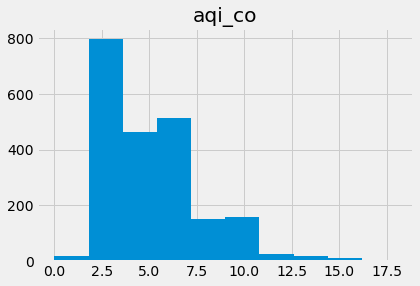

In [19]:
from matplotlib import style
style.use('fivethirtyeight')
df.hist('aqi_co', bins = 10)

array([[<AxesSubplot:title={'center':'aqi_no2'}>]], dtype=object)

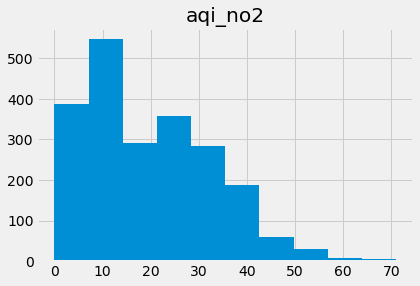

In [20]:
df.hist('aqi_no2', bins = 10)

array([[<AxesSubplot:title={'center':'aqi_o3'}>]], dtype=object)

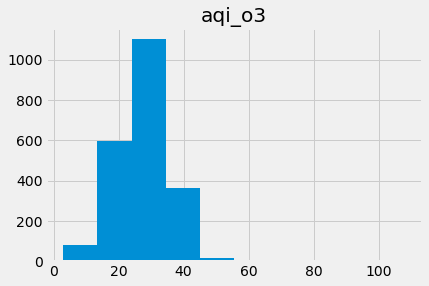

In [21]:
df.hist('aqi_o3', bins = 10)

array([[<AxesSubplot:title={'center':'aqi_pm_2_5'}>]], dtype=object)

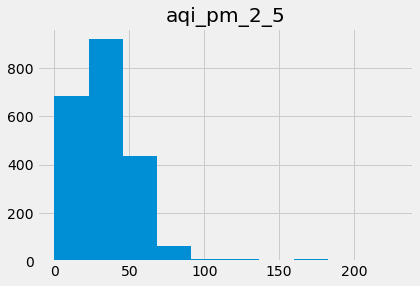

In [22]:
df.hist('aqi_pm_2_5', bins = 10)

array([[<AxesSubplot:title={'center':'aqi_pm_10'}>]], dtype=object)

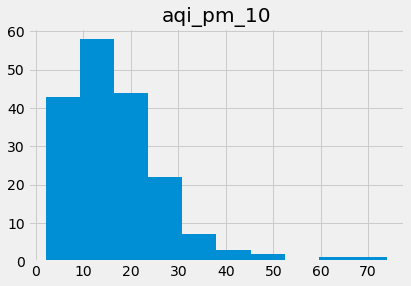

In [25]:
df.hist('aqi_pm_10', bins = 10)

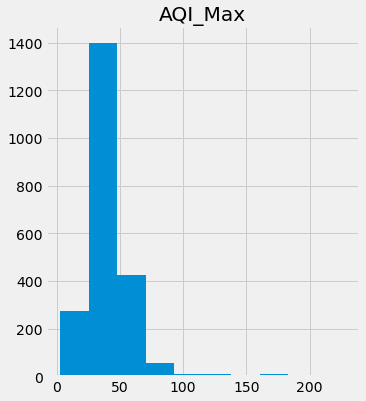

In [27]:
df.hist('AQI_Max', bins = 10, figsize = (5,6))
plt.savefig("aqimaxhist.png")

### Time Analysis

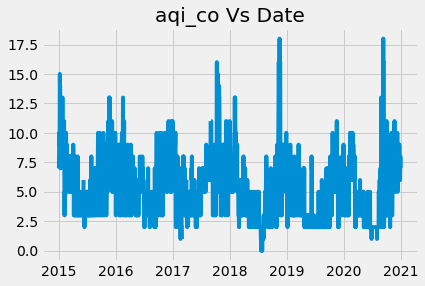

In [28]:
x_axis = df['Date']
y_axis = df['aqi_co']
plt.title('aqi_co Vs Date')
plt.plot(x_axis, y_axis)

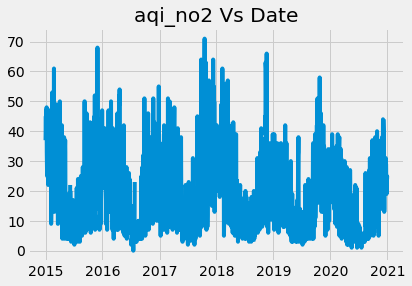

In [29]:
x_axis = df['Date']
y_axis = df['aqi_no2']
plt.title('aqi_no2 Vs Date')
plt.plot(x_axis, y_axis)

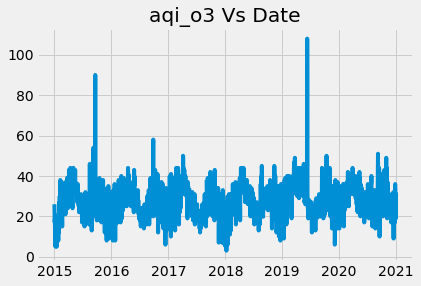

In [30]:
x_axis = df['Date']
y_axis = df['aqi_o3']
plt.title('aqi_o3 Vs Date')
plt.plot(x_axis, y_axis)

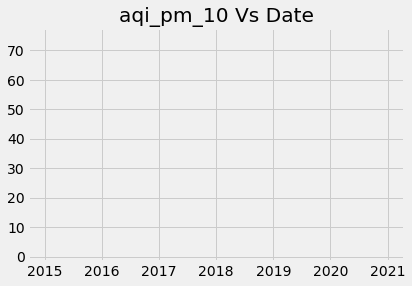

In [31]:
x_axis = df['Date']
y_axis = df['aqi_pm_10']
plt.title('aqi_pm_10 Vs Date')
plt.plot(x_axis, y_axis)

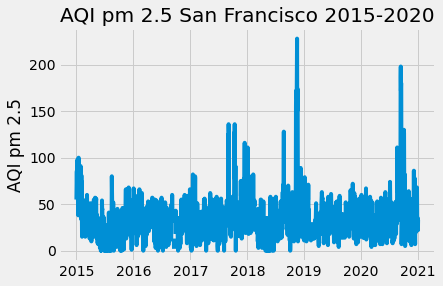

In [32]:
x_axis = df['Date']
y_axis = df['aqi_pm_2_5']
plt.title('AQI pm 2.5 San Francisco 2015-2020')
plt.plot(x_axis, y_axis)
plt.ylabel('AQI pm 2.5')
plt.savefig("aqi25.png")

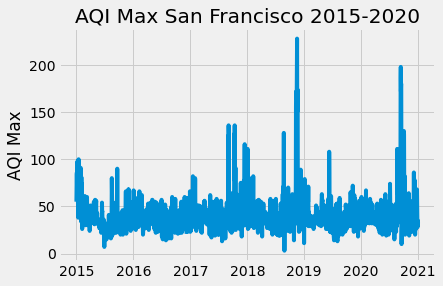

In [33]:
x_axis = df['Date']
y_axis = df['AQI_Max']
plt.title('AQI Max San Francisco 2015-2020')
plt.plot(x_axis, y_axis)
plt.ylabel('AQI Max')
plt.savefig("aqimax.png")

In [34]:
df_i = df.set_index(['Date'])

In [35]:
df_i.head()

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
Date,,,,,,
2015-01-01,7.0,37.0,26.0,55.0,NaN,55.0
2015-01-02,8.0,42.0,20.0,73.0,NaN,73.0
2015-01-03,10.0,45.0,17.0,84.0,NaN,84.0
2015-01-04,10.0,40.0,19.0,86.0,NaN,86.0
2015-01-05,9.0,42.0,12.0,69.0,NaN,69.0


In [36]:
df_y = df_i.resample("Y").mean()
df_y.head(6)

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
Date,,,,,,
2015-12-31,5.850000,22.419890,26.558011,29.985994,16.733333,38.331507
2016-12-31,5.587744,20.222535,26.341598,31.100575,15.033333,36.419178
2017-12-31,5.765043,22.102493,26.560224,36.824022,19.133333,42.504110
2018-12-31,4.926027,20.542936,27.013928,39.314448,17.333333,44.202740
2019-12-31,4.172603,18.080780,29.603352,31.284123,12.600000,37.616438
2020-12-31,4.961749,16.423077,29.416438,37.106557,19.935484,42.551913


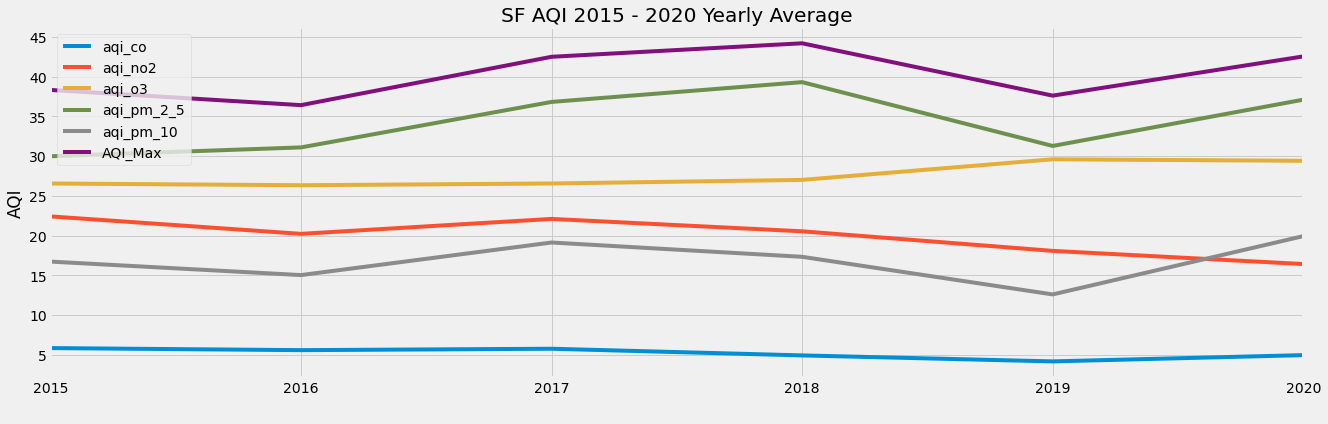

In [42]:
ax = df_y.plot(figsize = (20,6))
ax.set_title('SF AQI 2015 - 2020 Yearly Average')
ax.set_ylabel('AQI')
ax.set_xlabel(' ')
plt.savefig("yavgall.png")

In [40]:
df_q = df_i.resample("Q").mean()
df_q.head(6)

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
Date,,,,,,
2015-03-31,7.674157,30.922222,23.366667,47.044444,22.000000,50.355556
2015-06-30,4.089888,15.588889,32.685393,24.725275,14.857143,35.901099
2015-09-30,4.604396,14.021739,25.782609,18.466667,11.857143,29.804348
2015-12-31,7.032967,29.333333,24.505495,29.755814,17.375000,37.500000
2016-03-31,6.477778,27.373626,26.208791,33.791209,17.875000,39.472527
2016-06-30,5.191011,16.341176,30.077778,33.087912,13.500000,37.978022


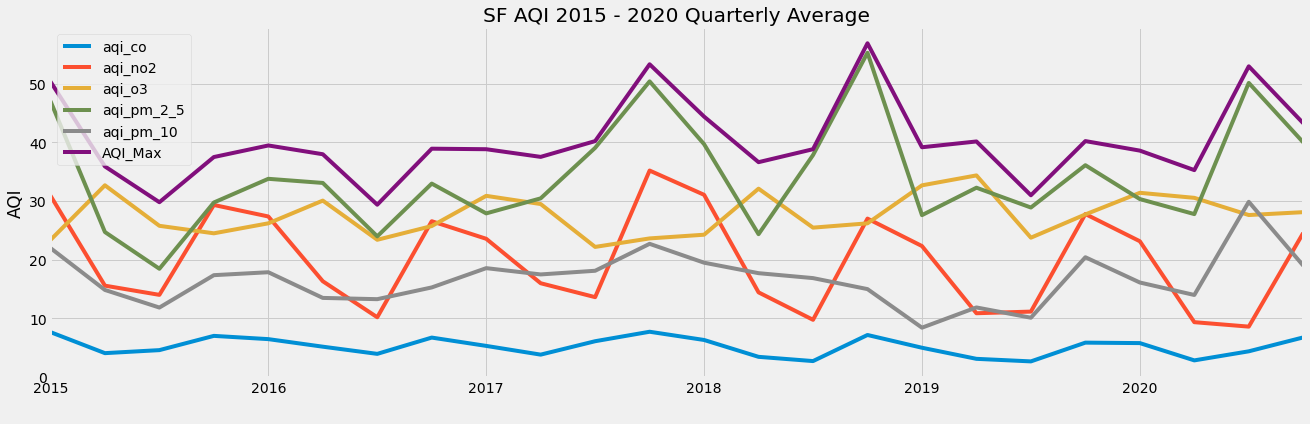

In [43]:
ax = df_q.plot(figsize = (20,6))
ax.set_title('SF AQI 2015 - 2020 Quarterly Average')
ax.set_ylabel('AQI')
ax.set_xlabel(' ')
plt.savefig("qavgall.png")

In [44]:
df_m = df_i.resample("M").mean()
df_m.head(6)

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
Date,,,,,,
2015-01-31,9.580645,35.290323,13.322581,65.935484,26.666667,65.935484
2015-02-28,7.178571,30.107143,26.178571,40.357143,17.000000,45.285714
2015-03-31,6.166667,27.290323,30.870968,34.193548,20.666667,39.354839
2015-04-30,4.866667,24.233333,36.700000,27.500000,13.000000,40.166667
2015-05-31,3.677419,11.870968,35.129032,25.032258,15.000000,38.064516
2015-06-30,3.714286,10.620690,25.678571,21.633333,16.500000,29.400000


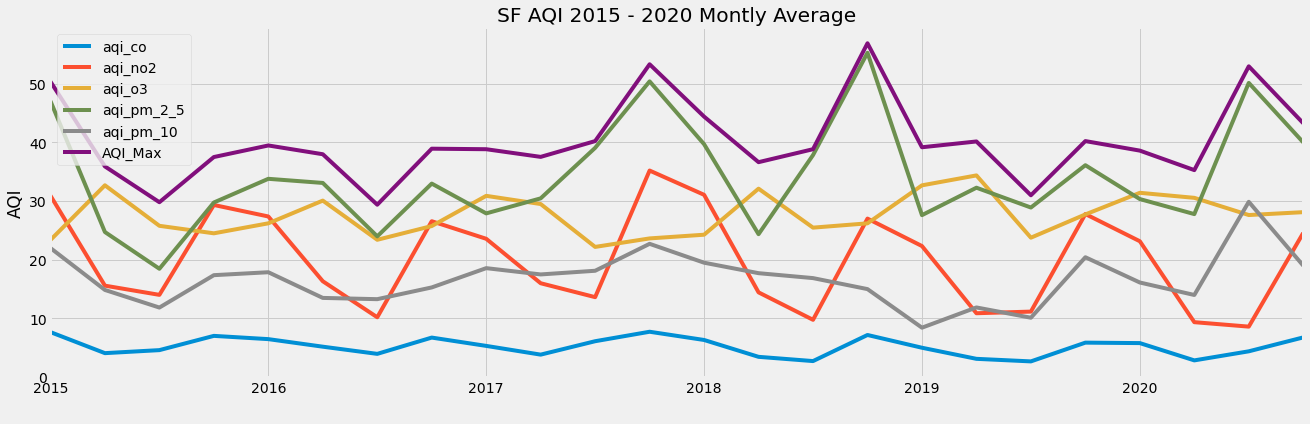

In [46]:
#plotting line to observe safe air below black line (Monthly resampled)

ax = df_q.plot(figsize = (20,6))
ax.set_title('SF AQI 2015 - 2020 Montly Average')
ax.set_ylabel('AQI')
ax.set_xlabel(' ')
plt.savefig("mavgall.png")

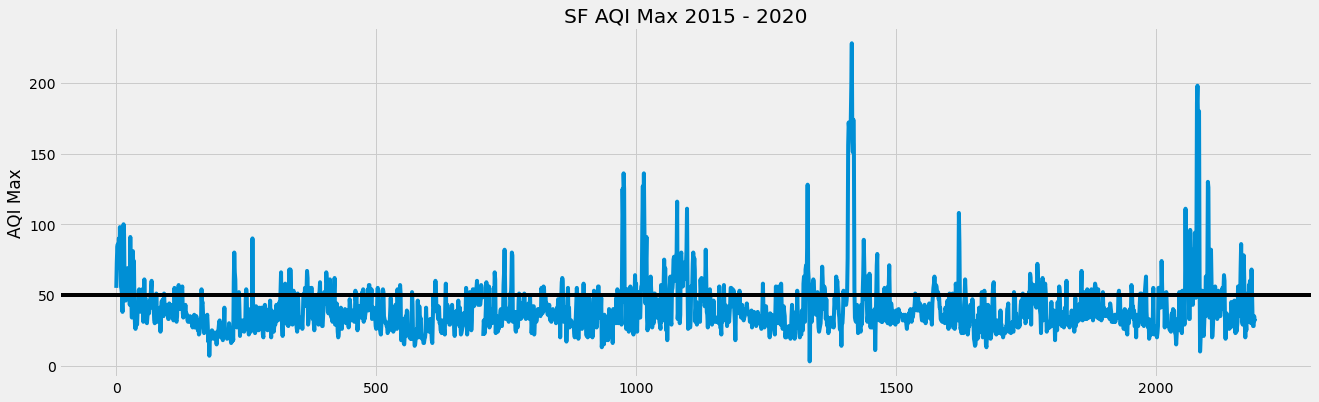

In [49]:
#plotting line to observe safe air below black line (Daily)

ax = df["AQI_Max"].plot(figsize = (20,6))
ax.set_title('SF AQI Max 2015 - 2020')
ax.set_ylabel('AQI Max')
plt.axhline(y = 50, color = 'black')
plt.savefig("aqimaxtre.png")

### Descriptive Statistics

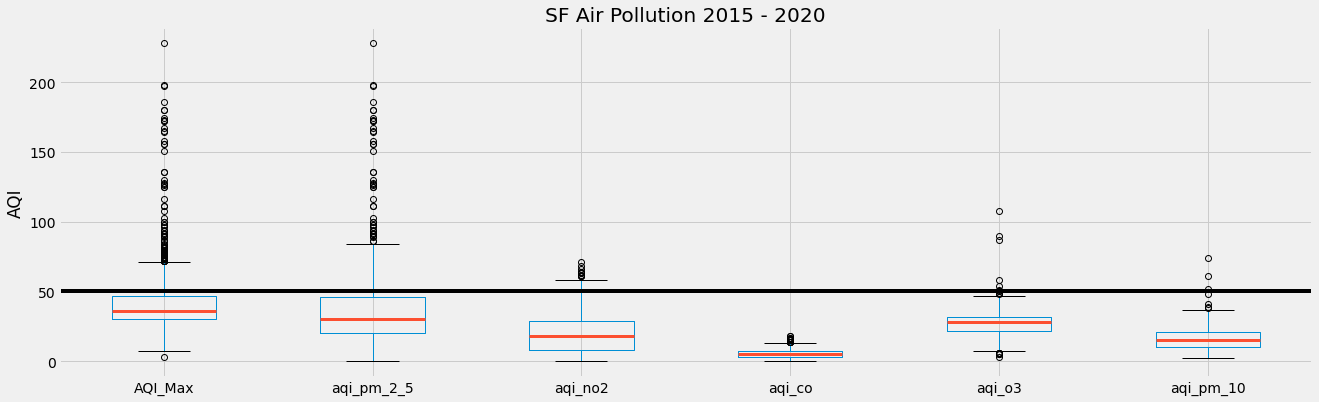

In [52]:
#from matplotlib import style
#style.use('fivethirtyeight')
boxplot = df.boxplot(column=['AQI_Max','aqi_pm_2_5','aqi_no2','aqi_co', 'aqi_o3', 'aqi_pm_10'], figsize = (20,6), medianprops={"linewidth": 3})
plt.title('SF Air Pollution 2015 - 2020')
#plt.xlabel('Pollutants')
plt.ylabel('AQI')
plt.axhline(y = 50, color = 'black')
plt.savefig("aqiallstat.png")

In [53]:
# Summary statistics
df.describe()

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
count,2164.000000,2162.000000,2164.000000,2141.000000,181.000000,2191.000000
mean,5.203789,19.962535,27.583641,34.283512,16.812155,40.272022
std,2.615535,12.879895,8.077235,22.850928,10.422628,19.047236
min,0.000000,0.000000,3.000000,0.000000,2.000000,3.000000
25%,3.000000,8.000000,22.000000,20.000000,10.000000,30.000000
50%,5.000000,18.000000,28.000000,30.000000,15.000000,36.000000
75%,7.000000,29.000000,32.000000,46.000000,21.000000,46.500000
max,18.000000,71.000000,108.000000,228.000000,74.000000,228.000000


## Prepare Data

In [54]:
# Drop Column Date
df = df.drop(columns=["Date"])

In [55]:
df.head()

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
0,7.0,37.0,26.0,55.0,NaN,55.0
1,8.0,42.0,20.0,73.0,NaN,73.0
2,10.0,45.0,17.0,84.0,NaN,84.0
3,10.0,40.0,19.0,86.0,NaN,86.0
4,9.0,42.0,12.0,69.0,NaN,69.0


In [56]:
df.shape

(2192, 6)

In [57]:
# Count of AQI_Max where it is Unsafe
print(df[(df.AQI_Max > 50)].count())

aqi_co        433
aqi_no2       435
aqi_o3        431
aqi_pm_2_5    436
aqi_pm_10      36
AQI_Max       437
dtype: int64


In [58]:
# Count of AQI_Max where it is Safe
print(df[(df.AQI_Max <= 50)].count())

aqi_co        1731
aqi_no2       1727
aqi_o3        1733
aqi_pm_2_5    1705
aqi_pm_10      145
AQI_Max       1754
dtype: int64


In [59]:
df.dtypes

aqi_co        float64
aqi_no2       float64
aqi_o3        float64
aqi_pm_2_5    float64
aqi_pm_10     float64
AQI_Max       float64
dtype: object

In [60]:
#Handle missing values
df.isnull().sum()

aqi_co          28
aqi_no2         30
aqi_o3          28
aqi_pm_2_5      51
aqi_pm_10     2011
AQI_Max          1
dtype: int64

In [61]:
# Replace missing values with the mean of the column
df_column = ['aqi_co', 'aqi_no2', 'aqi_o3', 'aqi_pm_2_5', 'aqi_pm_10', 'AQI_Max']

for i in df_column:
    a = df[i].mean()
    df[i].replace(np.nan , a,inplace = True)

In [62]:
df.isnull().sum()

aqi_co        0
aqi_no2       0
aqi_o3        0
aqi_pm_2_5    0
aqi_pm_10     0
AQI_Max       0
dtype: int64

In [63]:
# Convert the target column values to safe and unsafe based on their values

for aqi in df['AQI_Max']:
    if (aqi > float(50)):
        df['AQI_Max']=df['AQI_Max'].replace(aqi, "Unsafe")
    else:
        df['AQI_Max']=df['AQI_Max'].replace(aqi, "Safe")

In [64]:
df.head()

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
0,7.0,37.0,26.0,55.0,16.812155,Unsafe
1,8.0,42.0,20.0,73.0,16.812155,Unsafe
2,10.0,45.0,17.0,84.0,16.812155,Unsafe
3,10.0,40.0,19.0,86.0,16.812155,Unsafe
4,9.0,42.0,12.0,69.0,16.812155,Unsafe


In [65]:
df.dtypes

aqi_co        float64
aqi_no2       float64
aqi_o3        float64
aqi_pm_2_5    float64
aqi_pm_10     float64
AQI_Max        object
dtype: object

In [66]:
columns = ["aqi_co", "aqi_no2", "aqi_o3", "aqi_pm_2_5", "aqi_pm_10"]

target = ["AQI_Max"]

In [67]:
df.head()

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
0,7.0,37.0,26.0,55.0,16.812155,Unsafe
1,8.0,42.0,20.0,73.0,16.812155,Unsafe
2,10.0,45.0,17.0,84.0,16.812155,Unsafe
3,10.0,40.0,19.0,86.0,16.812155,Unsafe
4,9.0,42.0,12.0,69.0,16.812155,Unsafe


## Split the Data into Training and Testing

In [68]:
# Create our features
X = df.drop(columns='AQI_Max')

#clean features
X = pd.get_dummies(X)

# Create our target
y = df.loc[:, target].copy()
X.head()

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10
0,7.0,37.0,26.0,55.0,16.812155
1,8.0,42.0,20.0,73.0,16.812155
2,10.0,45.0,17.0,84.0,16.812155
3,10.0,40.0,19.0,86.0,16.812155
4,9.0,42.0,12.0,69.0,16.812155


In [69]:
X.describe()

,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10
count,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000
mean,5.203789,19.962535,27.583641,34.283512,16.812155
std,2.598768,12.791413,8.025458,22.583411,2.987393
min,0.000000,0.000000,3.000000,0.000000,2.000000
25%,3.000000,8.000000,22.000000,20.000000,16.812155
50%,5.000000,18.000000,28.000000,31.000000,16.812155
75%,7.000000,29.000000,32.000000,45.000000,16.812155
max,18.000000,71.000000,108.000000,228.000000,74.000000


In [70]:
# Check the balance of our target values
y["AQI_Max"].value_counts()

##We have imbalanced data.  Have significantly more observations in the class Safe.  Therefore we apply resampling
#techniques below

Safe      1755
Unsafe     437
Name: AQI_Max, dtype: int64

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

## Resampling


### Oversampling

#### Naive Random Oversampling

In [72]:
# Resample the training data with the RandomOversampler

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'AQI_Max': 1})

In [73]:
# Train the Logistic Regression model using the resampled data

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [74]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

0.9454408642051663


In [75]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,409,28
Actual 1,5,106


In [76]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Safe       0.99      0.94      0.95      0.96      0.95      0.89       437
     Unsafe       0.79      0.95      0.94      0.87      0.95      0.90       111

avg / total       0.95      0.94      0.95      0.94      0.95      0.89       548



#### SMOTE Oversampling

In [77]:
# Resample the training data with SMOTE

from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,sampling_strategy='auto').\
                            fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'AQI_Max': 1})

In [78]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [79]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

0.9420805244603871


In [80]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df

,Predicted 0,Predicted 1
Actual 0,409,28
Actual 1,5,106


In [81]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Safe       0.99      0.94      0.95      0.96      0.94      0.89       437
     Unsafe       0.80      0.95      0.94      0.86      0.94      0.89       111

avg / total       0.95      0.94      0.94      0.94      0.94      0.89       548



#### Undersampling

In [82]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete

from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'AQI_Max': 1})

In [83]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [84]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

0.9478013482590142


In [85]:
cluster_y_pred = y_pred


In [86]:
ccentroids_y_pred_df = pd.DataFrame(cluster_y_pred)
ccentroids_y_pred_df.head()

,0
0,Safe
1,Unsafe
2,Safe
3,Safe
4,Safe


In [87]:
prediction = ccentroids_y_pred_df.rename(columns={0: "Prediction"})

In [88]:
prediction.index.name = 'Observation'

In [89]:
prediction.head()

,Prediction
Observation,
0,Safe
1,Unsafe
2,Safe
3,Safe
4,Safe


In [90]:
#Load predictions into Postgres

# # # Import API key
# from config import db_password

# connection = psycopg2.connect(
#     host = 'finalproject-ml.cvm9etk63tz8.us-west-1.rds.amazonaws.com',
#     port = 5432,
#     user = 'postgres',
#     password = db_password,
#     database = 'postgres'
#     )
# cursor=connection.cursor()

# table_name = 'prediction'
# prediction.to_sql(table_name, con = connection, if_exists ='replace')

In [91]:
confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df

,Predicted 0,Predicted 1
Actual 0,409,28
Actual 1,5,106


In [92]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Safe       0.99      0.95      0.95      0.97      0.95      0.90       437
     Unsafe       0.83      0.95      0.95      0.88      0.95      0.90       111

avg / total       0.95      0.95      0.95      0.95      0.95      0.90       548



#### Combination (Over and Under) Sampling


In [93]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({'AQI_Max': 1})

In [94]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [95]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

0.9465128744304946


In [96]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,406,31
Actual 1,4,107


In [97]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Safe       0.99      0.93      0.96      0.96      0.95      0.89       437
     Unsafe       0.78      0.96      0.93      0.86      0.95      0.90       111

avg / total       0.95      0.94      0.96      0.94      0.95      0.89       548



## Ensemble Learners

### Balanced Random Forest Classifier

In [98]:
# Resample the training data with the BalancedRandomForestClassifier
# Create a random forest classifier.
rf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# Fitting the model
rf_model.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [99]:
# Calculated the balanced accuracy score
predictions = rf_model.predict(X_test)
acc_score = balanced_accuracy_score(y_test, predictions)
acc_score

1.0

In [100]:
# Display the confusion matrix

# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,437,0
Actual 1,0,111


In [101]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

       Safe       1.00      1.00      1.00      1.00      1.00      1.00       437
     Unsafe       1.00      1.00      1.00      1.00      1.00      1.00       111

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       548



In [102]:
# List the features sorted in descending order by feature importance

# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
#importances


# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.808657406053162, 'aqi_pm_2_5'),
 (0.09583456314677842, 'aqi_no2'),
 (0.06936800167098789, 'aqi_co'),
 (0.020562191677322907, 'aqi_o3'),
 (0.005577837451748767, 'aqi_pm_10')]

### Easy Ensemble AdaBoost Classifier

In [103]:
# Train the EasyEnsembleClassifier
ee_model = EasyEnsembleClassifier(n_estimators=100, random_state=1)

# Fitting the model
ee_model.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [104]:
# Calculated the balanced accuracy score
y_pred = ee_model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

1.0


In [105]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,437,0
Actual 1,0,111


In [106]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Safe       1.00      1.00      1.00      1.00      1.00      1.00       437
     Unsafe       1.00      1.00      1.00      1.00      1.00      1.00       111

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       548



# Models Performance Summary

In [107]:
Summary_AQI_Max_Prediction_Safe = pd.DataFrame(
    {"Naive Random Oversampling":{'AccuracyScore': 0.94, 'Precision': 0.99, "Recall":0.94, "F1-Score":0.96},
     "SMOTE Oversampling":{'AccuracyScore': 0.94, 'Precision': 0.99, "Recall":0.94,"F1-Score":0.96},
     "ClusterCentroids":{'AccuracyScore': 0.95, 'Precision': 0.99, "Recall":0.95,"F1-Score":0.97},
     "SMOTEEN":{'AccuracyScore': 0.94, 'Precision': 0.99, "Recall":0.93,"F1-Score":0.96},
     "Random Forest Classifier":{'AccuracyScore': 1, 'Precision': 1, "Recall":1,"F1-Score":1},
     "Easy Ensemble Classifier -AdaBoost":{'AccuracyScore': 1, 'Precision': 1, "Recall":1,"F1-Score":1}
     })
    
Summary_AQI_Max_Prediction_Safe

,Naive Random Oversampling,SMOTE Oversampling,ClusterCentroids,SMOTEEN,Random Forest Classifier,Easy Ensemble Classifier -AdaBoost
AccuracyScore,0.94,0.94,0.95,0.94,1,1
Precision,0.99,0.99,0.99,0.99,1,1
Recall,0.94,0.94,0.95,0.93,1,1
F1-Score,0.96,0.96,0.97,0.96,1,1


In [108]:
Summary_AQI_Max_Prediction_Safe.index.name = 'Score'
Summary_AQI_Max_Prediction_Safe['Category'] = ['Safe', 'Safe', 'Safe', 'Safe']
Summary_AQI_Max_Prediction_Safe = Summary_AQI_Max_Prediction_Safe.reset_index()
summary_safe = Summary_AQI_Max_Prediction_Safe.set_index(['Category','Score'])
summary_safe

Naive Random Oversampling  SMOTE Oversampling  \
Category Score                                                          
Safe     AccuracyScore                       0.94                0.94   
         Precision                           0.99                0.99   
         Recall                              0.94                0.94   
         F1-Score                            0.96                0.96   

                        ClusterCentroids  SMOTEEN  Random Forest Classifier  \
Category Score                                                                
Safe     AccuracyScore              0.95     0.94                         1   
         Precision                  0.99     0.99                         1   
         Recall                     0.95     0.93                         1   
         F1-Score                   0.97     0.96                         1   

                        Easy Ensemble Classifier -AdaBoost  
Category Score                                              
Safe     AccuracyScore                                   1  
         Precision                                       1  
         Recall                                          1  
         F1-Score                                        1

In [112]:
Summary_AQI_Max_Prediction_Unsafe = pd.DataFrame(
    {"Naive Random Oversampling":{'AccuracyScore': 0.94, 'Precision': 0.79, "Recall":0.95,"F1-Score":0.87},
      "SMOTE Oversampling":{'AccuracyScore': 0.94, 'Precision': 0.80, "Recall":0.95,"F1-Score":0.86},
     "ClusterCentroids":{'AccuracyScore': 0.95, 'Precision': 0.83, "Recall":0.95,"F1-Score":0.88},
     "SMOTEEN":{'AccuracyScore': 0.94, 'Precision': 0.78, "Recall":0.96,"F1-Score":0.86},
     "Random Forest Classifier":{'AccuracyScore': 1, 'Precision': 1, "Recall":1,"F1-Score":1},
     "Easy Ensemble Classifier -AdaBoost":{'AccuracyScore': 1, 'Precision': 1, "Recall":1,"F1-Score":1}
     })
    
Summary_AQI_Max_Prediction_Unsafe

,Naive Random Oversampling,SMOTE Oversampling,ClusterCentroids,SMOTEEN,Random Forest Classifier,Easy Ensemble Classifier -AdaBoost
AccuracyScore,0.94,0.94,0.95,0.94,1,1
Precision,0.79,0.80,0.83,0.78,1,1
Recall,0.95,0.95,0.95,0.96,1,1
F1-Score,0.87,0.86,0.88,0.86,1,1


In [113]:
Summary_AQI_Max_Prediction_Unsafe.index.name = 'Score'
Summary_AQI_Max_Prediction_Unsafe['Category'] = ['Unsafe', 'Unsafe', 'Unsafe', 'Unsafe']
Summary_AQI_Max_Prediction_Unsafe = Summary_AQI_Max_Prediction_Unsafe.reset_index()
summary_Unsafe = Summary_AQI_Max_Prediction_Unsafe.set_index(['Category','Score'])
summary_Unsafe

Naive Random Oversampling  SMOTE Oversampling  \
Category Score                                                          
Unsafe   AccuracyScore                       0.94                0.94   
         Precision                           0.79                0.80   
         Recall                              0.95                0.95   
         F1-Score                            0.87                0.86   

                        ClusterCentroids  SMOTEEN  Random Forest Classifier  \
Category Score                                                                
Unsafe   AccuracyScore              0.95     0.94                         1   
         Precision                  0.83     0.78                         1   
         Recall                     0.95     0.96                         1   
         F1-Score                   0.88     0.86                         1   

                        Easy Ensemble Classifier -AdaBoost  
Category Score                                              
Unsafe   AccuracyScore                                   1  
         Precision                                       1  
         Recall                                          1  
         F1-Score                                        1

In [114]:
consolidated_summary = pd.concat([summary_safe, summary_Unsafe])
consolidated_summary

Naive Random Oversampling  SMOTE Oversampling  \
Category Score                                                          
Safe     AccuracyScore                       0.94                0.94   
         Precision                           0.99                0.99   
         Recall                              0.94                0.94   
         F1-Score                            0.96                0.96   
Unsafe   AccuracyScore                       0.94                0.94   
         Precision                           0.79                0.80   
         Recall                              0.95                0.95   
         F1-Score                            0.87                0.86   

                        ClusterCentroids  SMOTEEN  Random Forest Classifier  \
Category Score                                                                
Safe     AccuracyScore              0.95     0.94                         1   
         Precision                  0.99     0.99                         1   
         Recall                     0.95     0.93                         1   
         F1-Score                   0.97     0.96                         1   
Unsafe   AccuracyScore              0.95     0.94                         1   
         Precision                  0.83     0.78                         1   
         Recall                     0.95     0.96                         1   
         F1-Score                   0.88     0.86                         1   

                        Easy Ensemble Classifier -AdaBoost  
Category Score                                              
Safe     AccuracyScore                                   1  
         Precision                                       1  
         Recall                                          1  
         F1-Score                                        1  
Unsafe   AccuracyScore                                   1  
         Precision                                       1  
         Recall                                          1  
         F1-Score                                        1